## Import libraries and dataset

In [1]:
import numpy as np
import importlib.util
import matplotlib.pyplot as plt
import seaborn as sns
from repetitive_optimizer import *
from optimized_random_response import *

import warnings

warnings.filterwarnings("ignore")


latent_load_module = importlib.util.spec_from_file_location("load_latent",
                                                            "/Users/sandarujayawardana/Documents/Python_code/Service_oriented_privacy_mechanisms/load_latent.py")
latent_load = importlib.util.module_from_spec(latent_load_module)
latent_load_module.loader.exec_module(latent_load)

X_train, y_train, X_test, y_test = latent_load.pre_process_celebA(TRAINING_AMOUNT = 0.9)



## JIDT 

In [2]:
'''
    Initialize JIDT software
    JIDT - https://github.com/jlizier/jidt

    Modified accordingly
'''

from jpype import *
import sys

JIDT_PATH = "/Users/sandarujayawardana/Downloads/infodynamics-dist-1.6.1/"

sys.path.append(JIDT_PATH + "demos/python")

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = JIDT_PATH + "infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)


In [3]:
'''
    Calculate pair-wise MI values

    Input: Data, calculate significance, estimator, time diff
    Output: List of pair-wise MI values
'''

def pair_wise_mutual_info(dataRaw, is_sign = False, estimator = "KSG", time_diff = 0):
    
    if isinstance(dataRaw, np.ndarray):
        data = dataRaw
    else:
        data = np.array(dataRaw)
    
    # 1. Construct the calculator:
    if estimator == "KSG":
        calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov2
    elif estimator == "Gaussian":
        calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
    else:
        assert "Unkown estimator"
    calc = calcClass()
    # 2. Set any properties to non-default values:
    calc.setProperty("TIME_DIFF", str(time_diff))

    no_of_columns = np.shape(data)[1]

    output = []

    print("no_of_columns ", no_of_columns)
    
    # Compute for all pairs:
    for s in range(no_of_columns):
        print("s ", s)
        inner_result = []
        for d in range(no_of_columns):
            # For each source-dest pair:
            if (s == d):
                inner_result.append(0)
                continue
            source = JArray(JDouble, 1)(data[:, s].tolist())
            destination = JArray(JDouble, 1)(data[:, d].tolist())
    
            # 3. Initialise the calculator for (re-)use:
            calc.initialise()
            # 4. Supply the sample data:
            calc.setObservations(source, destination)
            # 5. Compute the estimate:
            result = calc.computeAverageLocalOfObservations()
            # 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
            inner_result.append(result)
            if is_sign:
                measDist = calc.computeSignificance(100)
                print("p-value ", measDist.pValue)
        output.append(inner_result)
    print(np.shape(output))
    return np.array(output)


## PCA analysis

In [4]:
# Parameters

NUM_DISCRETE_VALUES = 16
CLIP_ = 0
NUM_AXES = 512
SOLVER = "SCS"
ATTRIBUTE = 'Male'
MAX_UTILITY_ERR_ALOWED = 0.1


ATTRIBUTE_DICT = {'5_o_Clock_Shadow': 1, 'Arched_Eyebrows': 2, 'Attractive': 3, 'Bags_Under_Eyes': 4, 'Bald': 5, 'Bangs': 6, 'Big_Lips': 7, 'Big_Nose': 8, 'Black_Hair': 9, 'Blond_Hair': 10, 'Blurry': 11, 'Brown_Hair': 12, 'Bushy_Eyebrows': 13, 'Chubby': 14, 'Double_Chin': 15, 'Eyeglasses': 16, 'Goatee': 17, 'Gray_Hair': 18, 'Heavy_Makeup': 19, 'High_Cheekbones': 20, 'Male': 21, 'Mouth_Slightly_Open': 22, 'Mustache': 23, 'Narrow_Eyes': 24, 'No_Beard': 25, 'Oval_Face': 26, 'Pale_Skin': 27, 'Pointy_Nose': 28, 'Receding_Hairline': 29, 'Rosy_Cheeks': 30, 'Sideburns': 31, 'Smiling': 32, 'Straight_Hair': 33, 'Wavy_Hair': 34, 'Wearing_Earrings': 35, 'Wearing_Hat': 36, 'Wearing_Lipstick': 37, 'Wearing_Necklace': 38, 'Wearing_Necktie': 39, 'Young': 40}
ATTRIBUTE_NUM = ATTRIBUTE_DICT[ATTRIBUTE]

ACTUAL_NUM_DISCRETE_VALUES = NUM_DISCRETE_VALUES - int(NUM_DISCRETE_VALUES * CLIP_)*2

In [5]:
class Transformer:
    def __init__(self, data, num_of_discrete_value):
        self.min__ = np.min(data)
        self.range__ = np.max(data) - self.min__
        self.num_of_discrete_value = num_of_discrete_value - 1 # correction
    
    def transform(self, value):
        normalized_data = (value - self.min__)/self.range__
        return normalized_data*self.num_of_discrete_value
    
    def inverse_transform(self, value):
        return (value/self.num_of_discrete_value) * self.range__ + self.min__

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train_ori = X_train

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

pca = PCA(n_components=NUM_AXES)
X_train = pca.fit_transform(X_train)

transpose_x_train = np.transpose(X_train)

transpose_transform_x_train = np.zeros((np.shape(transpose_x_train)[0], np.shape(transpose_x_train)[1]))
pca_axis_transformer_list = []

for i in range(NUM_AXES):
    pca_axis_transformer_list.append(Transformer(data=transpose_x_train[i], num_of_discrete_value=NUM_DISCRETE_VALUES))
    transpose_transform_x_train[i] = pca_axis_transformer_list[-1].transform(transpose_x_train[i])
    
# X_recovered = pca.inverse_transform(X_pca)
# X_original_unscaled = scaler.inverse_transform(X_recovered)

In [7]:
def get_histogram(dist, num_bins):
    counts, bin_edges = np.histogram(dist, bins=num_bins, density=True)
    # Combine counts and bin edges into a single array
    # histogram = np.array([bin_edges[:-1], bin_edges[1:], counts])
    return counts

def get_discrete_value(actual_value, discrete_values):
    discrete_value = round(actual_value)
    
    if discrete_value < discrete_values[0]:
        return discrete_values[0]
    elif discrete_value > discrete_values[-1]:
        return discrete_values[-1]
    
    return discrete_value

    # len_ = len(discrete_values)

    # if len_ == 1:
    #     return discrete_values[0]
    # elif len_ == 2:
    #     return discrete_values[0] if abs(actual_value - discrete_values[0]) < abs(actual_value - discrete_values[1]) else discrete_values[1]

    # mid_index = int(len_/2)

    # if actual_value > discrete_values[mid_index]:
    #     return get_discrete_value(actual_value=actual_value, discrete_values=discrete_values[mid_index:])
    # else:
    #     return get_discrete_value(actual_value=actual_value, discrete_values=discrete_values[:mid_index])

def get_attribute_dist(x_data, y_data, attr_no, discrete_values):
    attribute_dist = {}
    for i in discrete_values:
        attribute_dist[i] = []

    count_positive = 0
    for i in range(len(x_data)):
        if y_data[i][attr_no] == 1:
            count_positive += 1
    print("Positive ", count_positive)
    print("Negative ", len(x_data) - count_positive)

    positive_coefficient = 1 #(len(x_data) - count_positive)/count_positive
    print("positive_coefficient ", positive_coefficient)

    len_count = 0

    for i, value in enumerate(x_data):
        discrete_value = get_discrete_value(actual_value=value, discrete_values=discrete_values)
        attr_value = int(y_data[i][attr_no])
        if attr_value == 1:
            attr_value *= positive_coefficient
            len_count += attr_value
        else:
            len_count += 1
        attribute_dist[discrete_value].append(attr_value)
    
    for i in discrete_values:
        attribute_dist[i] = np.sum(np.array(attribute_dist[i]))/len_count # len(attribute_dist[i])
    
    return attribute_dist

def increase_error_matrix(matrix):
    __increase = 1.5
    __dim = len(matrix)

    for i in range(__dim):
        for j in range(__dim):
            matrix[i][j] = matrix[i][j]*__increase
            matrix[i][j] = 1 if matrix[i][j] > 1 else matrix[i][j]
    return matrix

def cal_error_matrix(x_data, y_data, attr_no, discrete_values):
    print(np.shape(x_data), np.shape(y_data))
    NO_DISCRETE_STATE = len(discrete_values)
    error_matrix = np.zeros((NO_DISCRETE_STATE, NO_DISCRETE_STATE))

    attribute_dist = get_attribute_dist(x_data, y_data, attr_no, discrete_values)

    for i in range(NO_DISCRETE_STATE):
        for j in range(NO_DISCRETE_STATE):
            error_matrix[i][j] = abs(attribute_dist[i] - attribute_dist[j])
    np.nan_to_num(error_matrix, copy=False)  
    return increase_error_matrix(error_matrix/np.max(error_matrix))

## Histogram Calculation

In [8]:
histogram_list = []

for axis__ in range(NUM_AXES):
    histogram_list.append(get_histogram(dist=transpose_transform_x_train[axis__], num_bins=NUM_DISCRETE_VALUES))
    # print(np.sum(histogram_list[-1]))

## Optimization

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


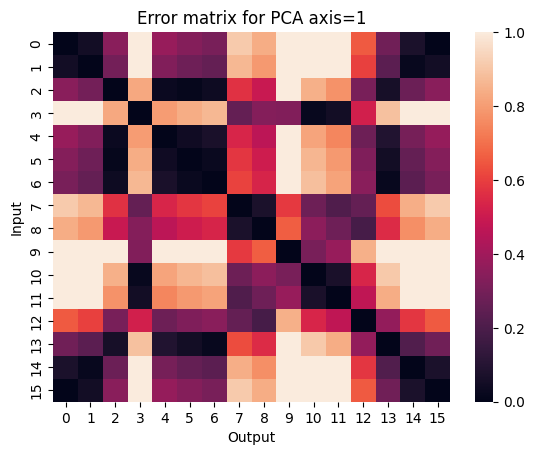

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


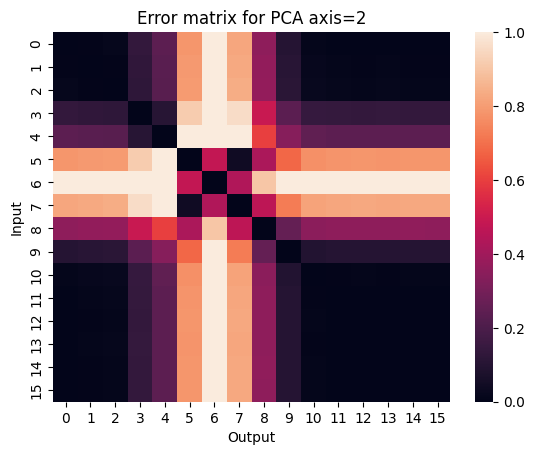

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


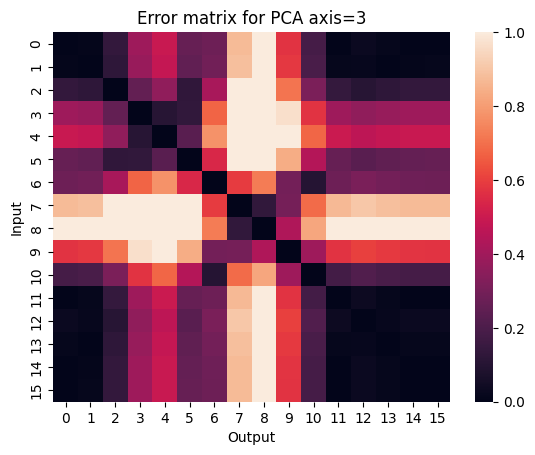

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


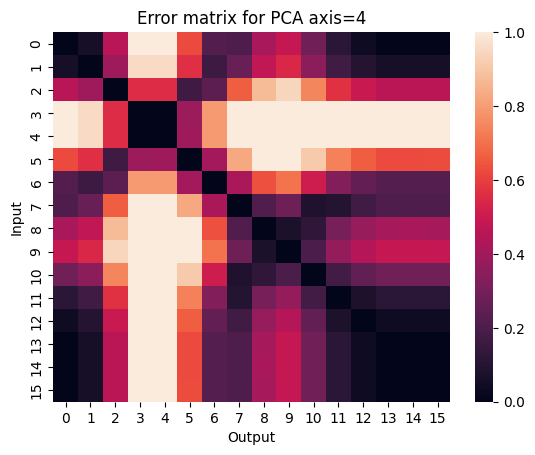

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


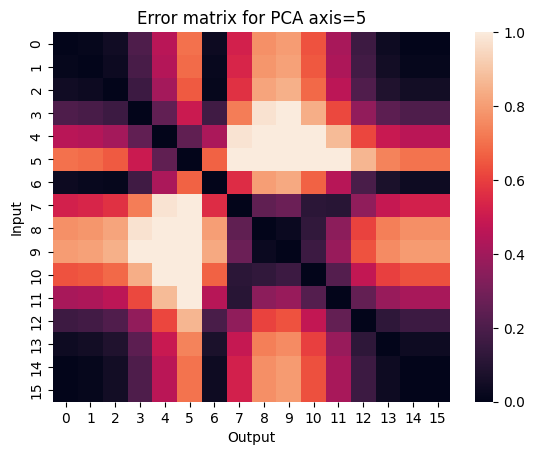

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


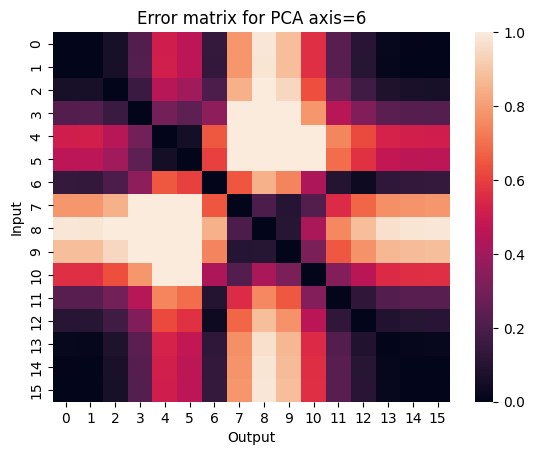

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


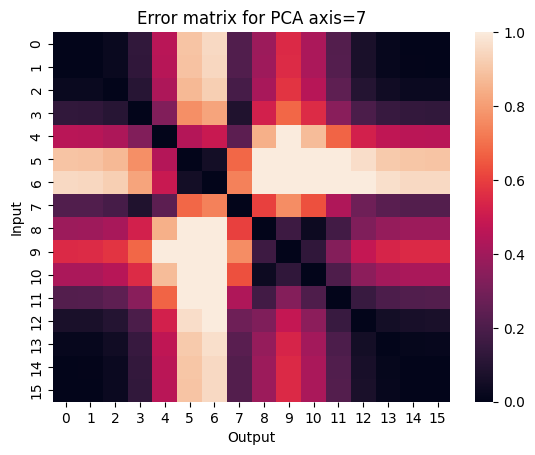

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


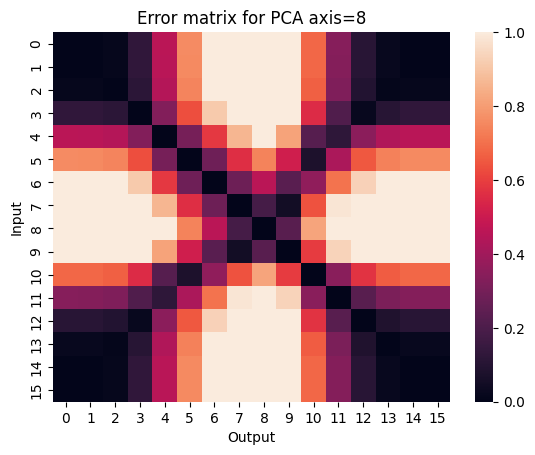

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


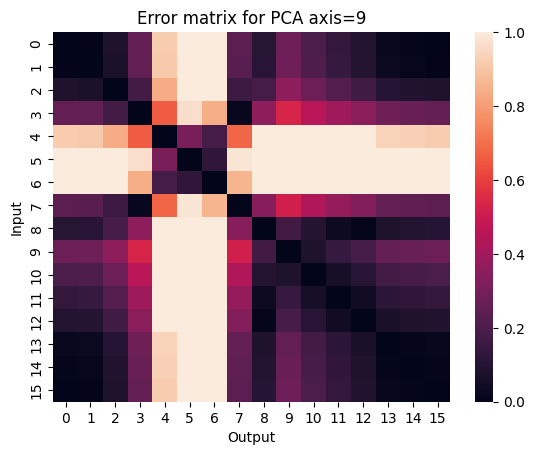

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


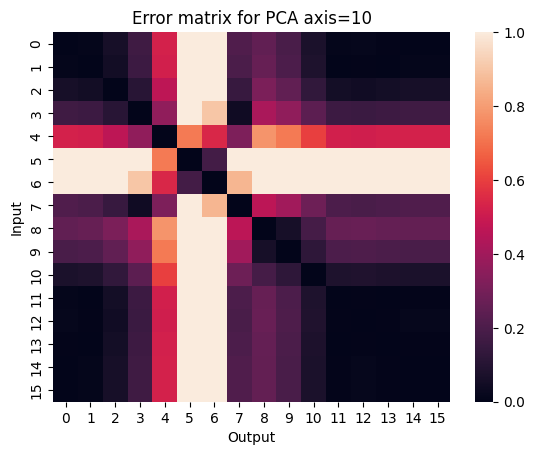

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


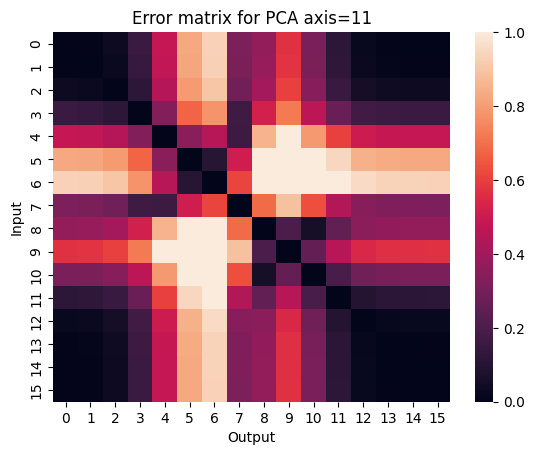

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


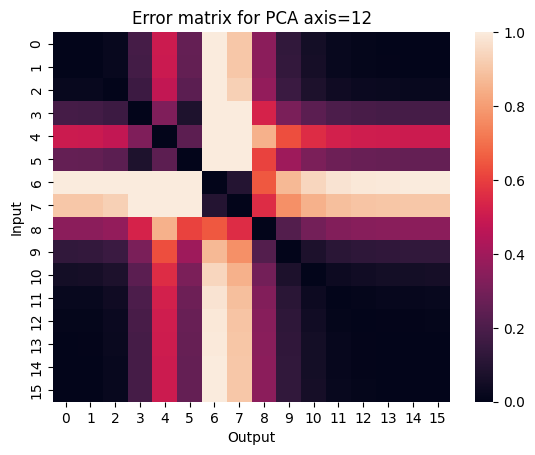

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


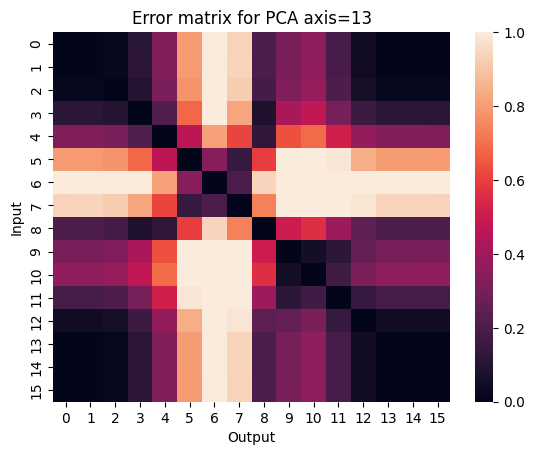

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


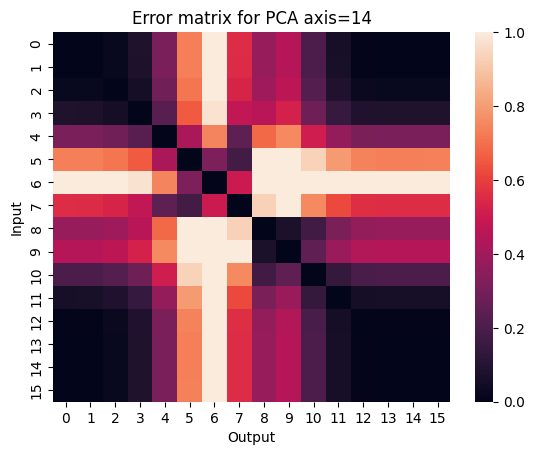

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


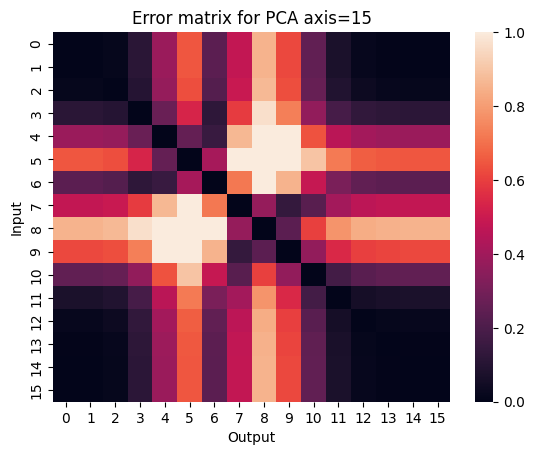

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


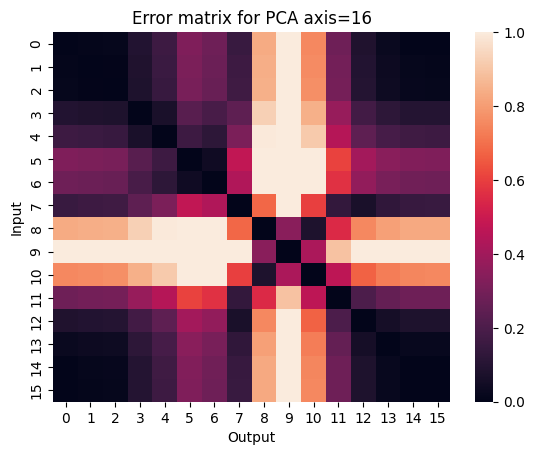

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


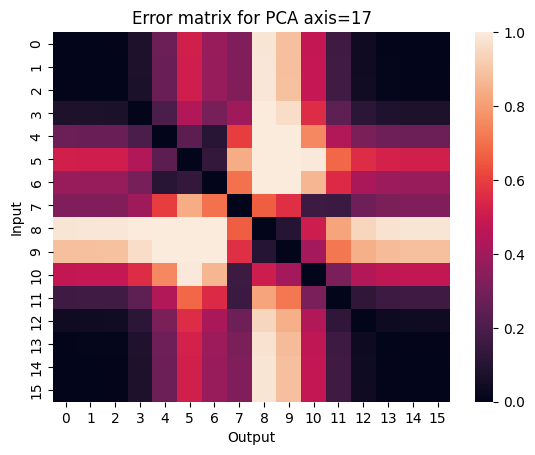

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


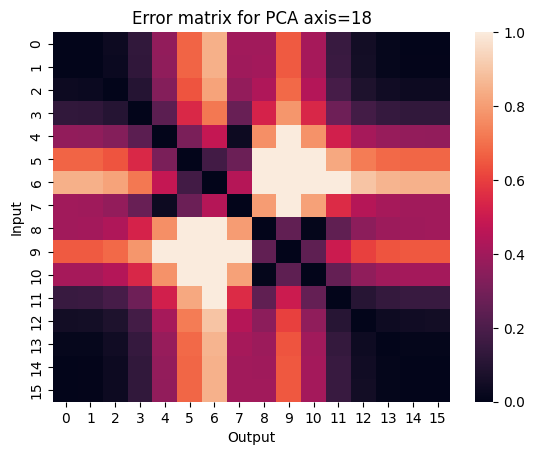

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


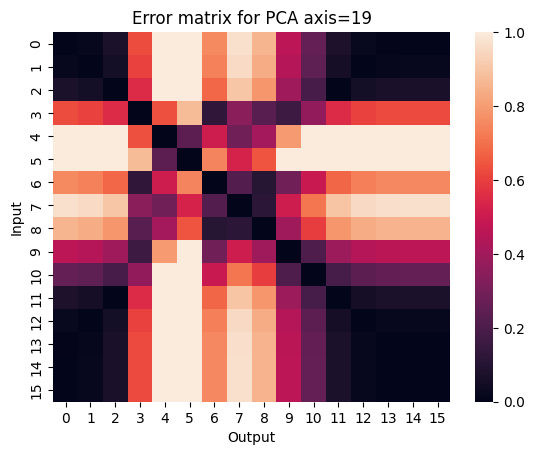

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


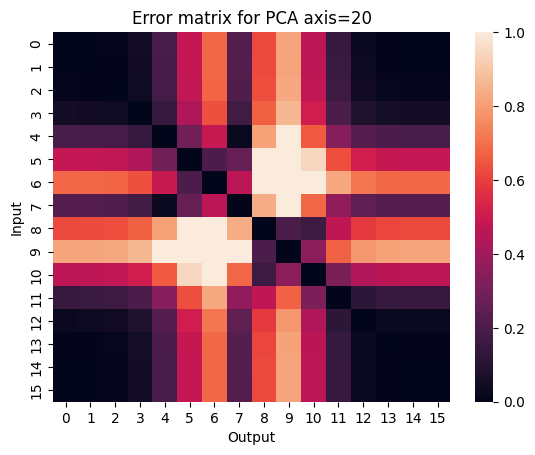

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


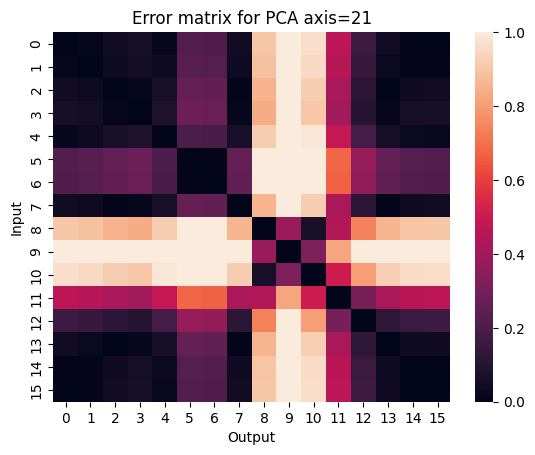

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


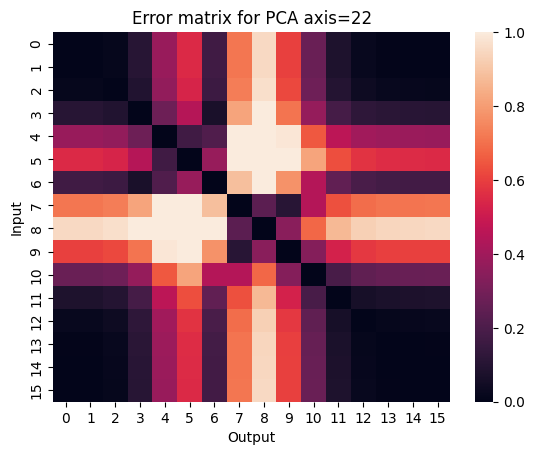

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


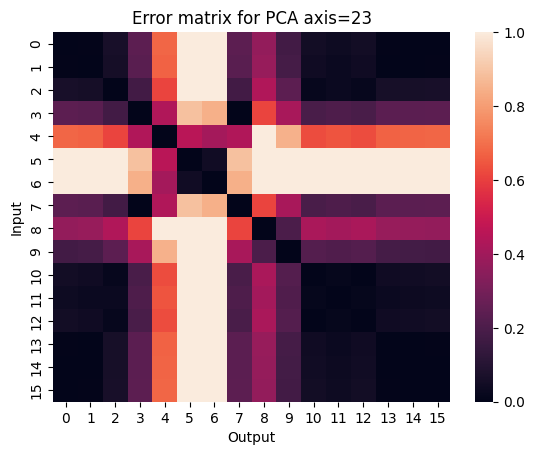

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


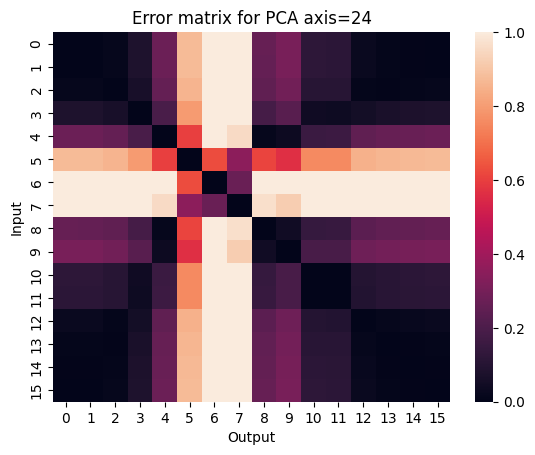

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


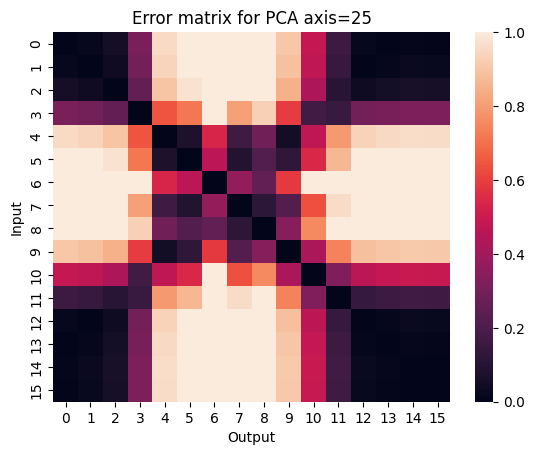

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


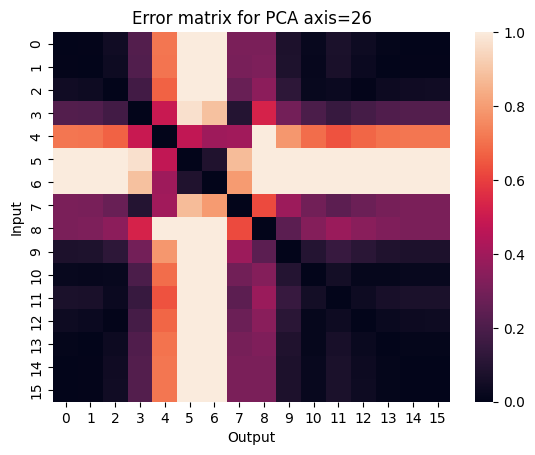

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


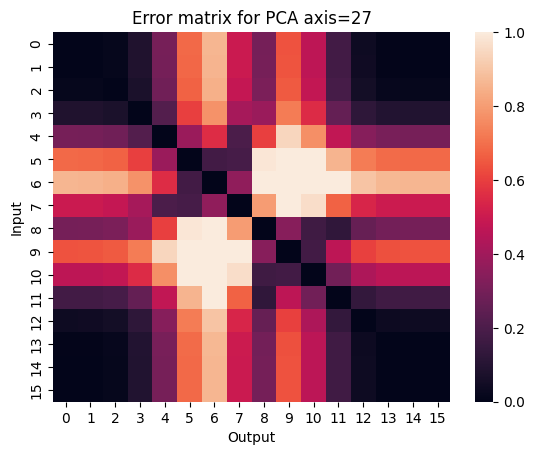

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


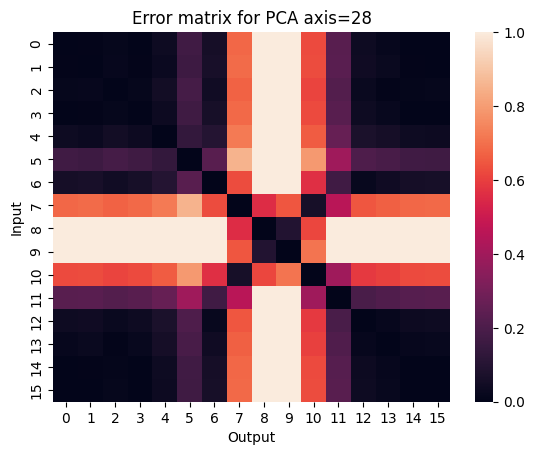

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


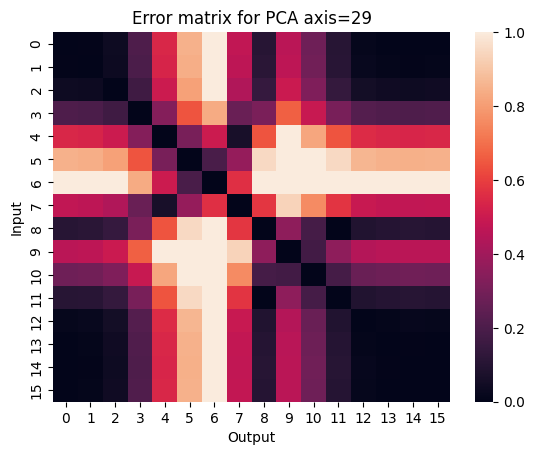

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


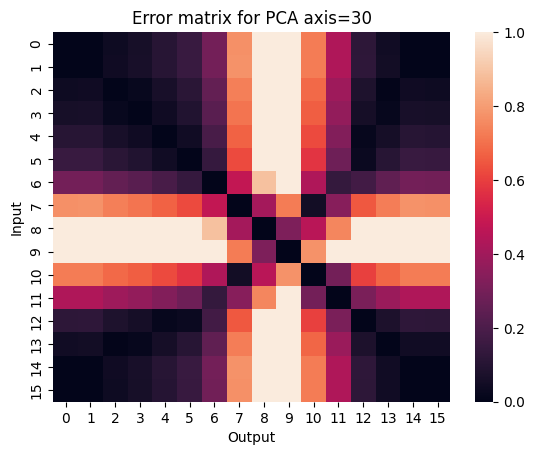

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


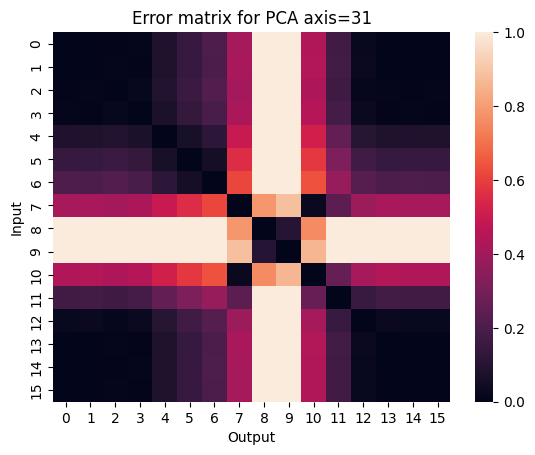

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


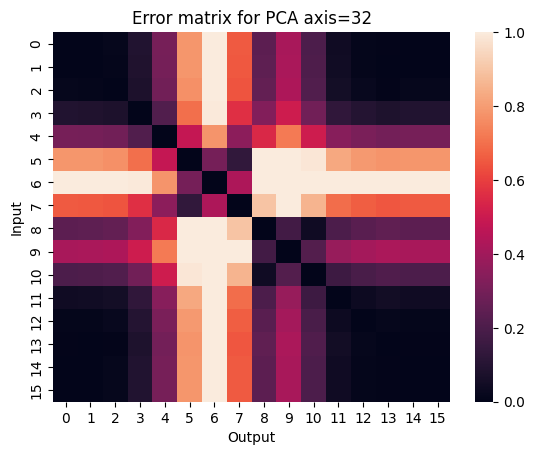

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


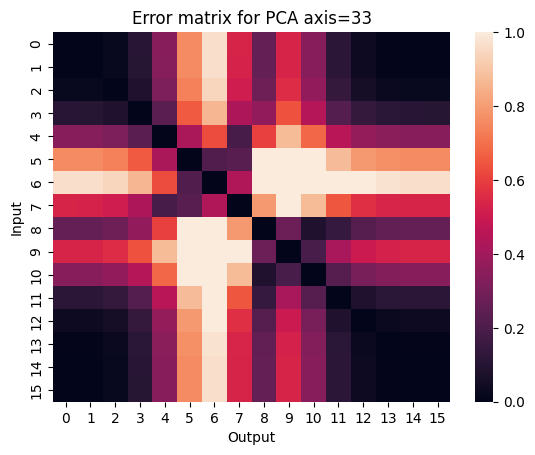

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


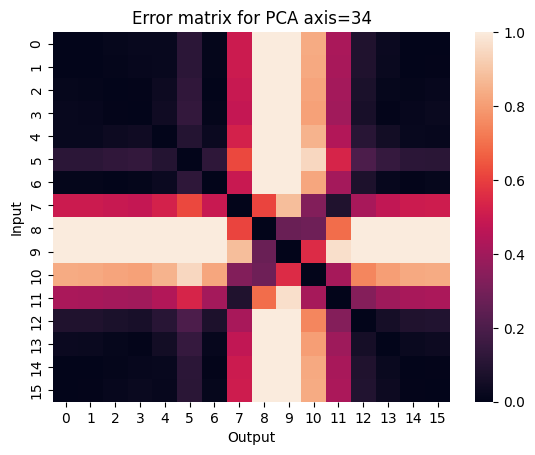

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


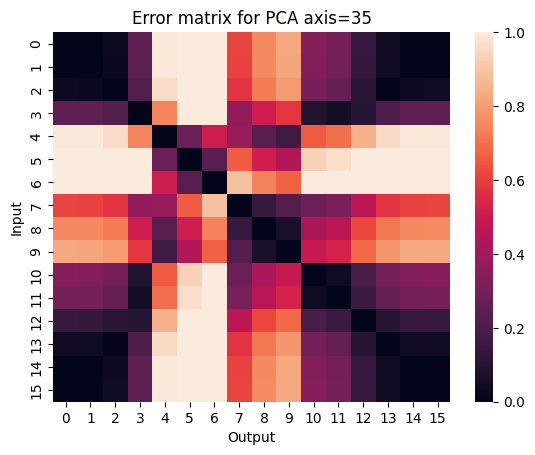

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


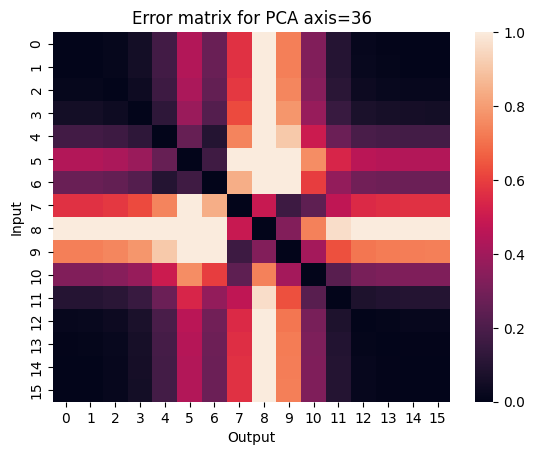

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


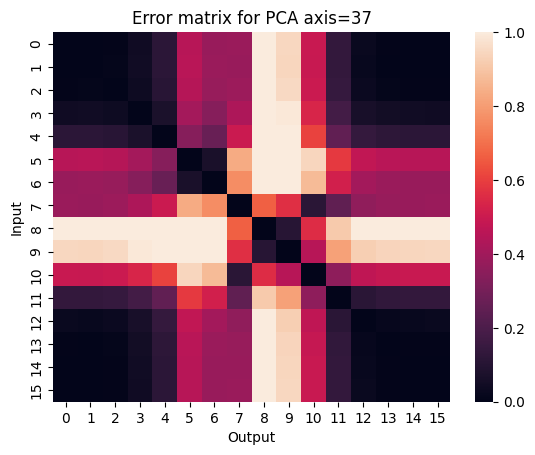

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


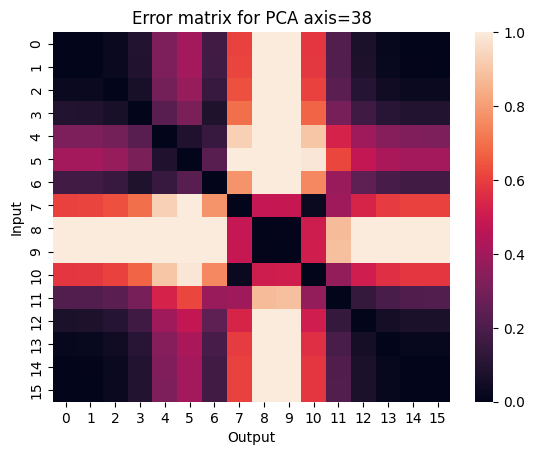

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


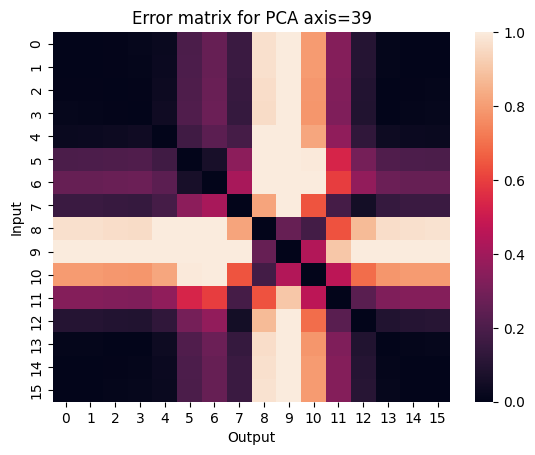

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


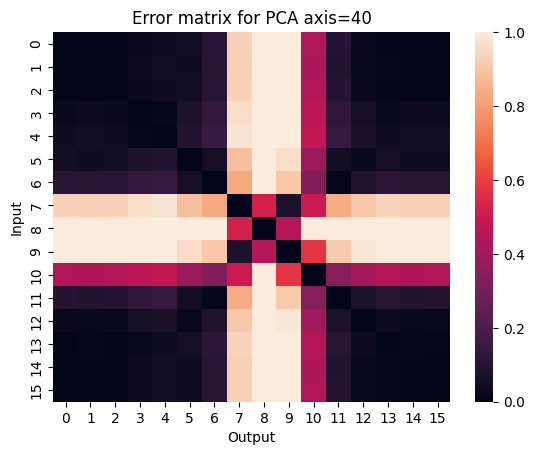

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


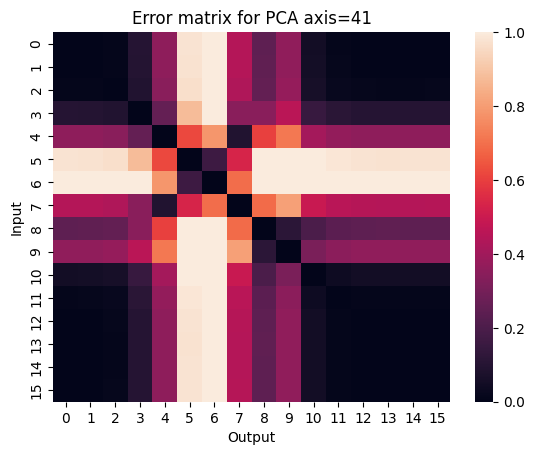

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


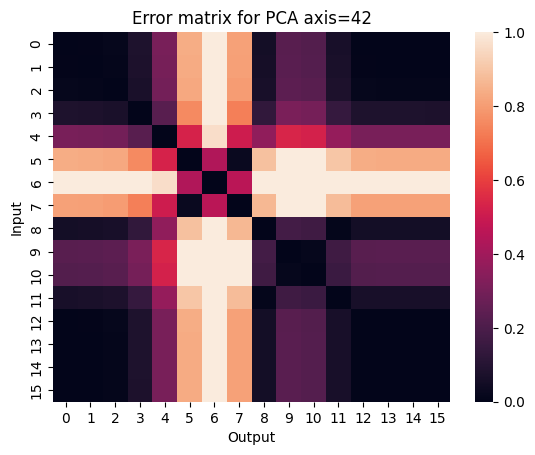

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


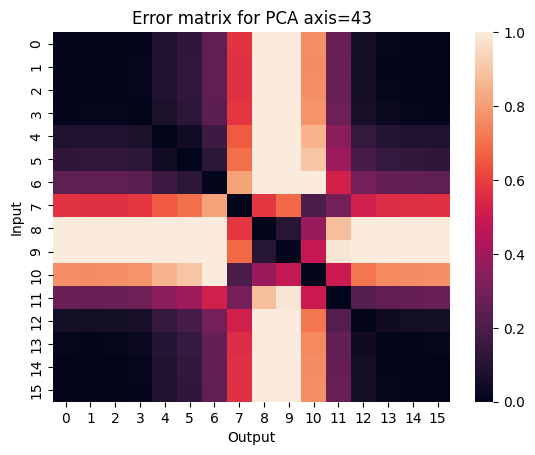

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


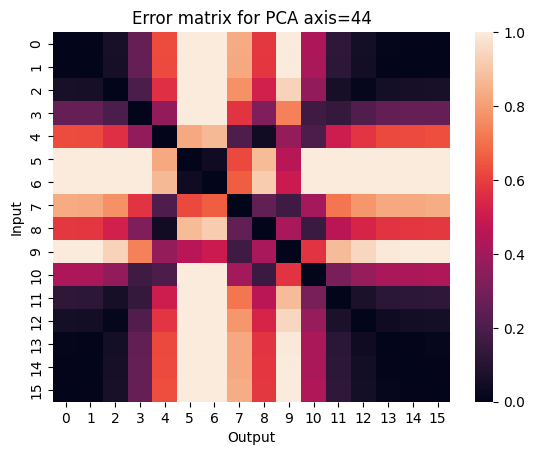

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


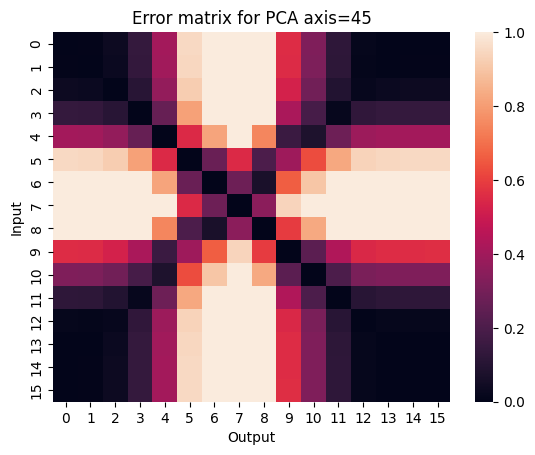

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


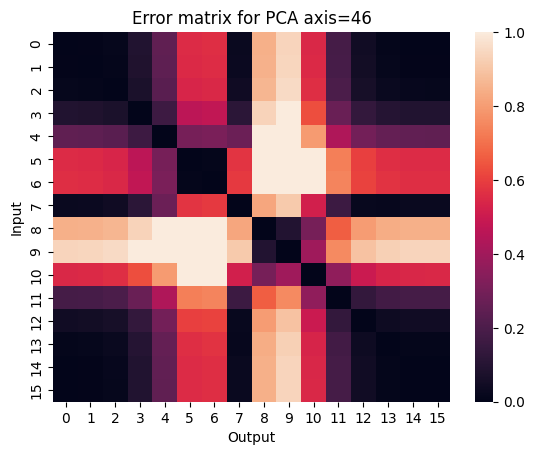

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


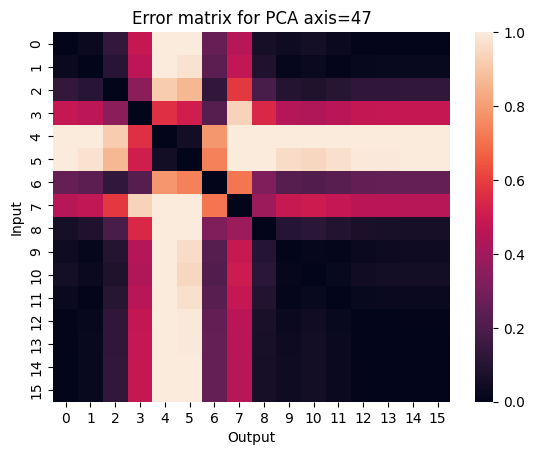

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


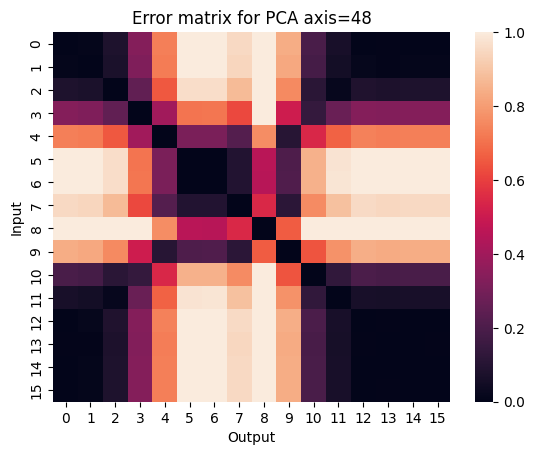

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


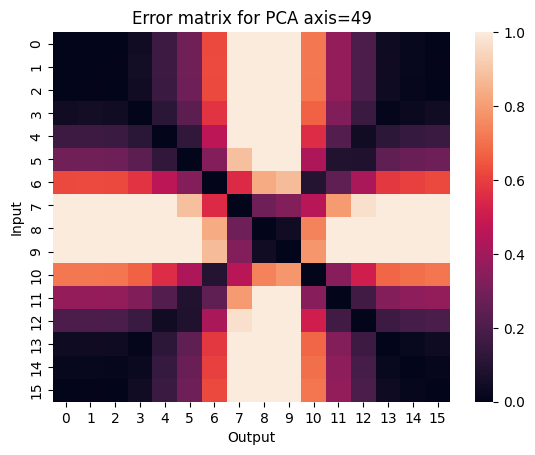

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


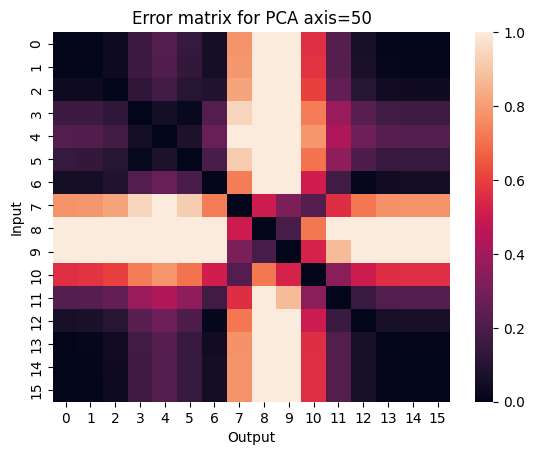

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


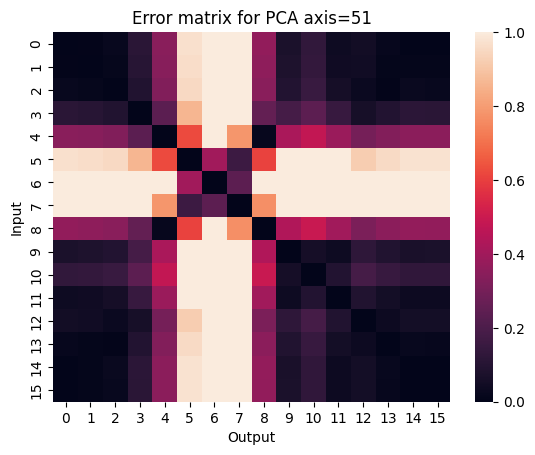

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


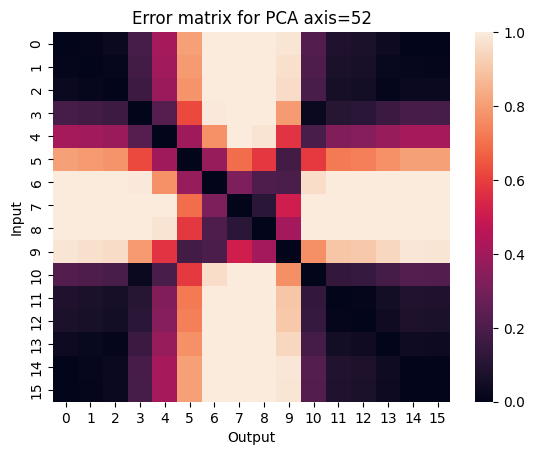

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


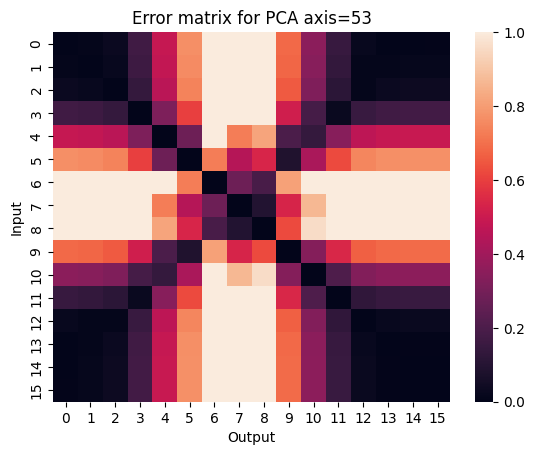

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


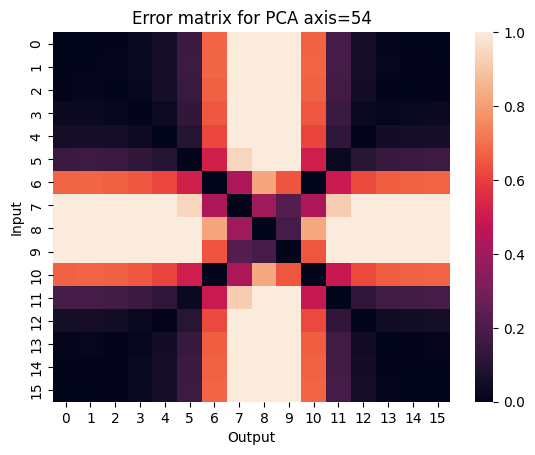

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


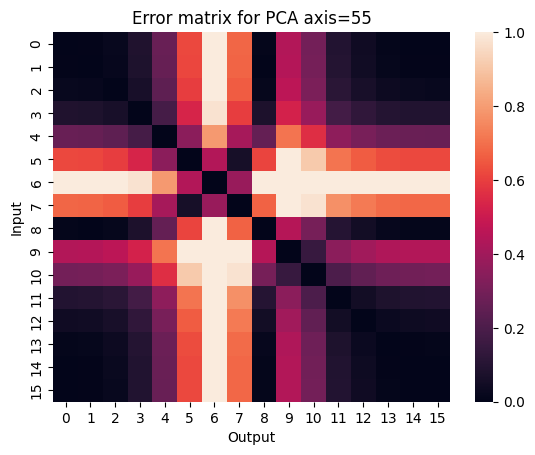

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


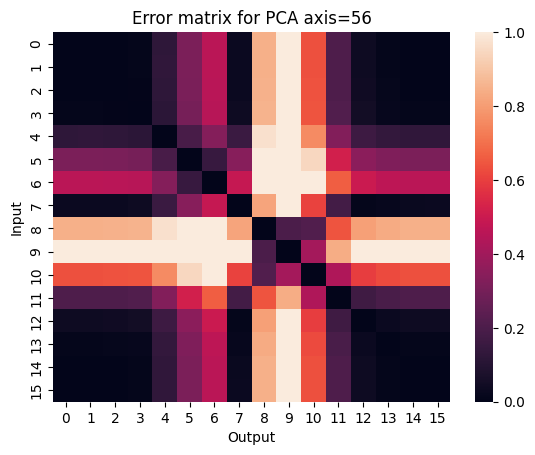

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


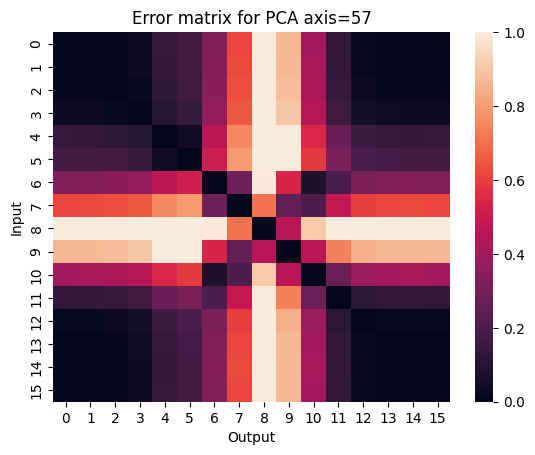

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


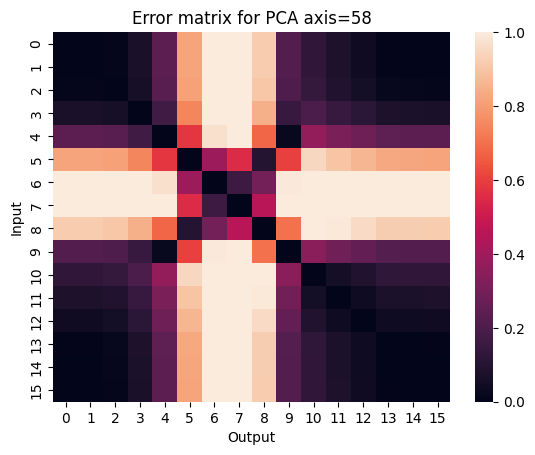

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


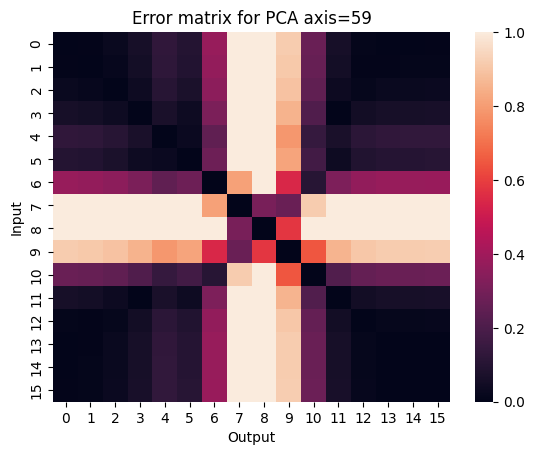

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


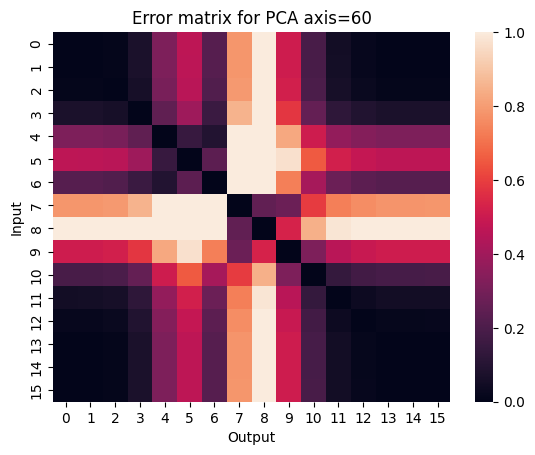

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


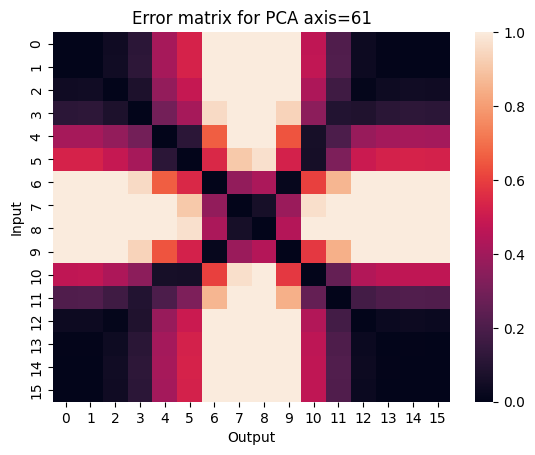

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


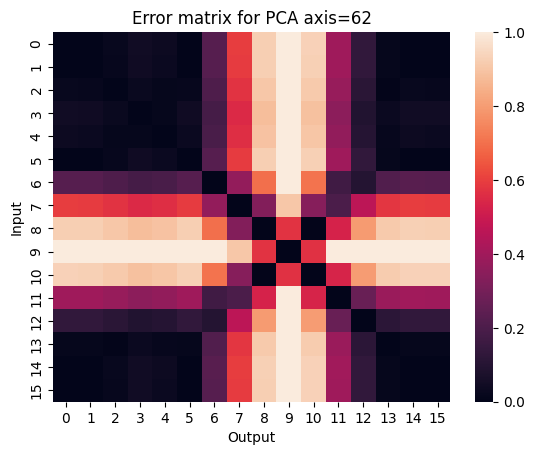

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


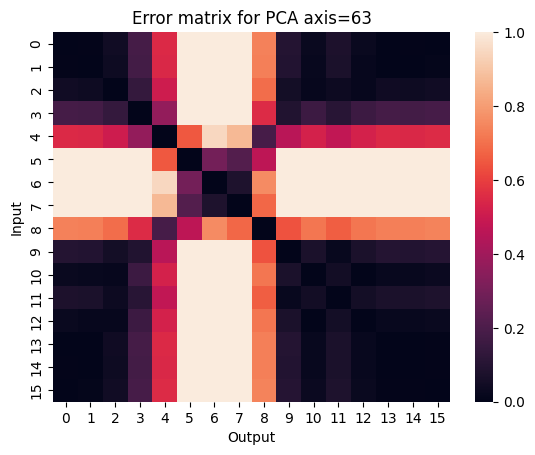

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


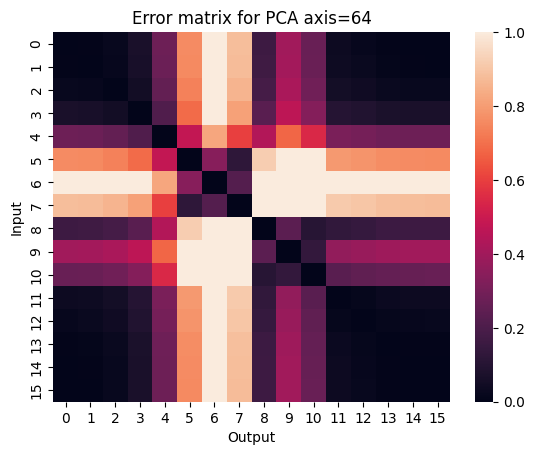

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


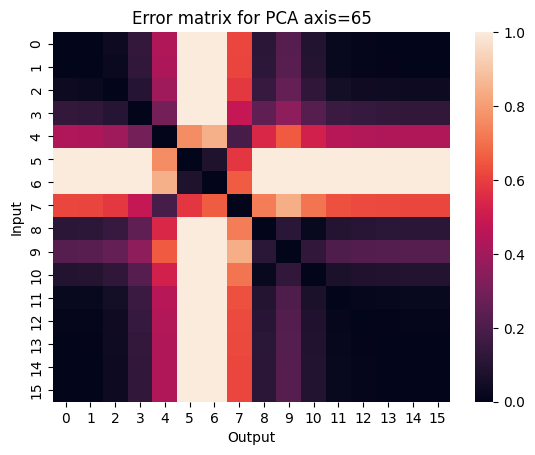

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


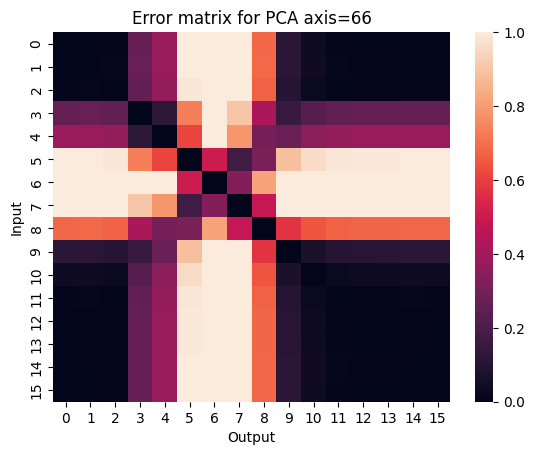

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


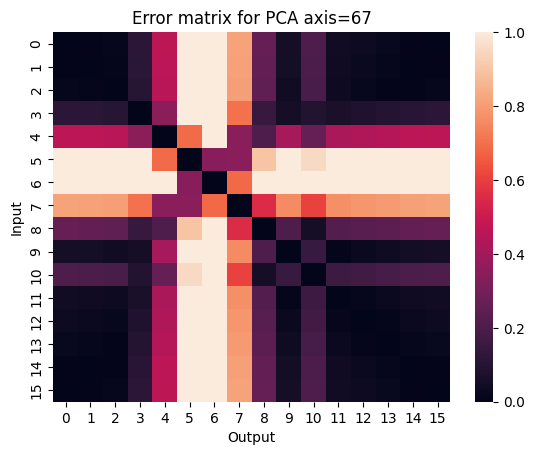

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


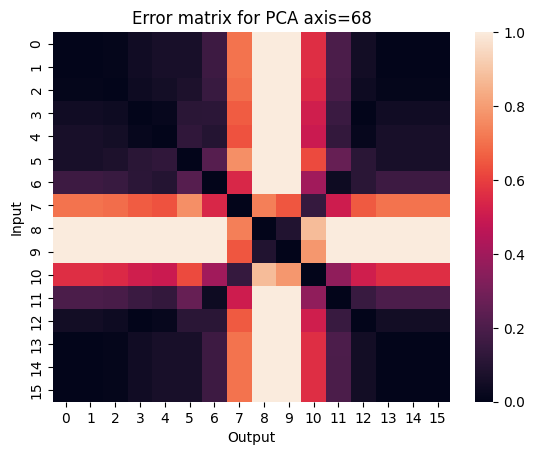

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


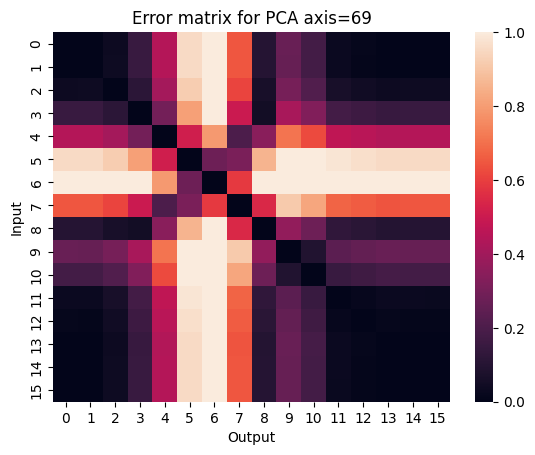

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


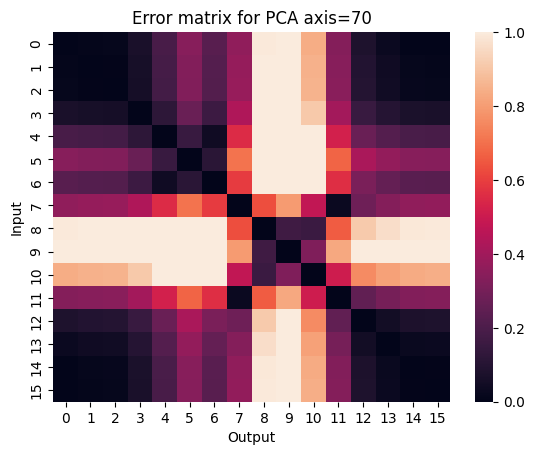

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


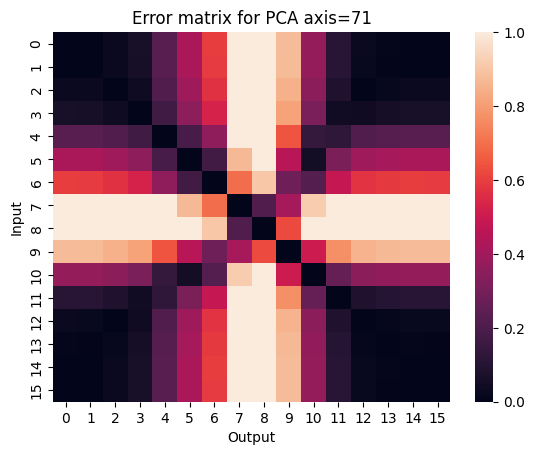

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


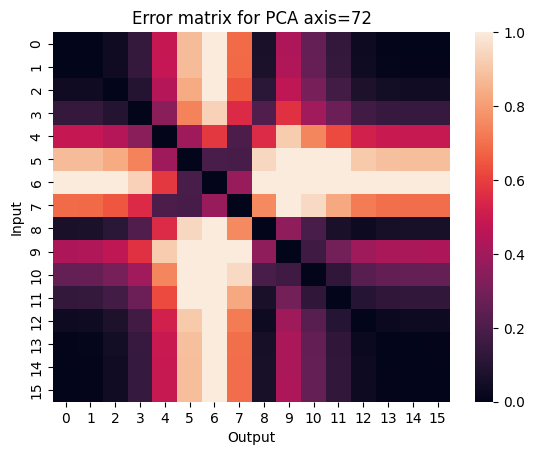

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


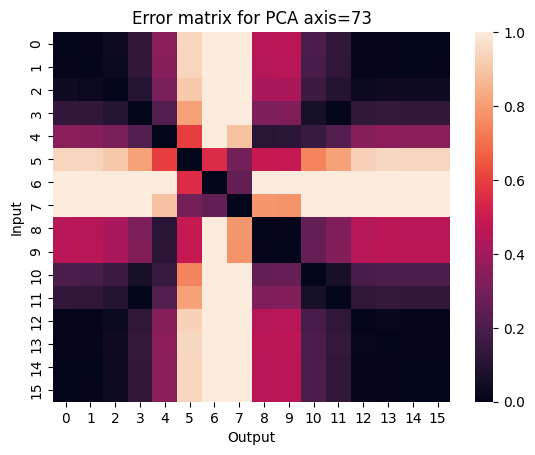

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


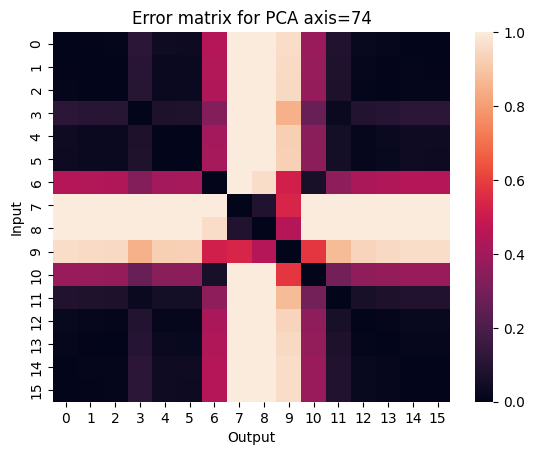

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


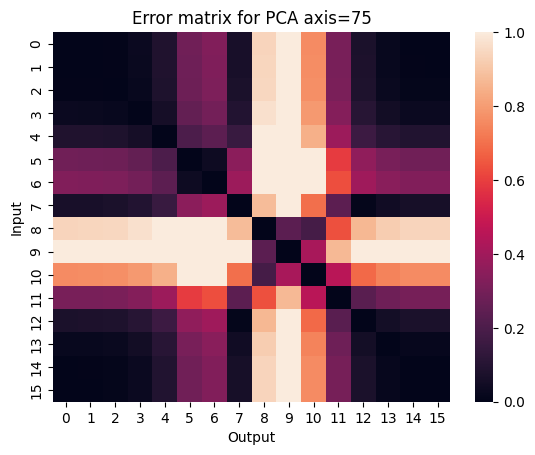

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


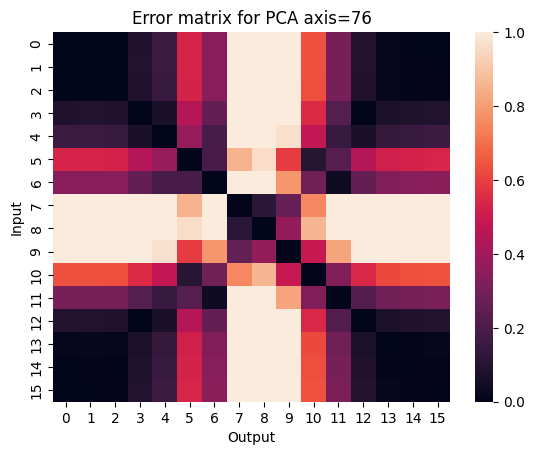

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


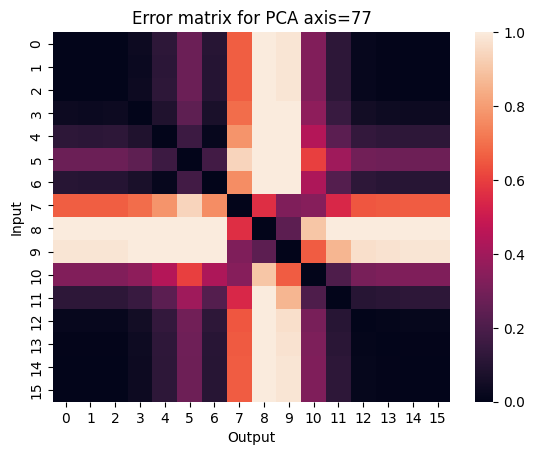

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


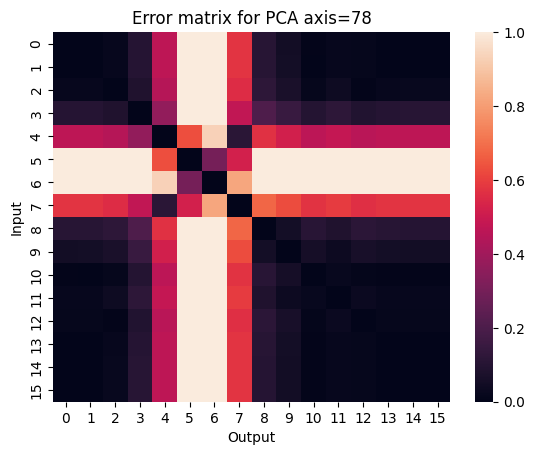

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


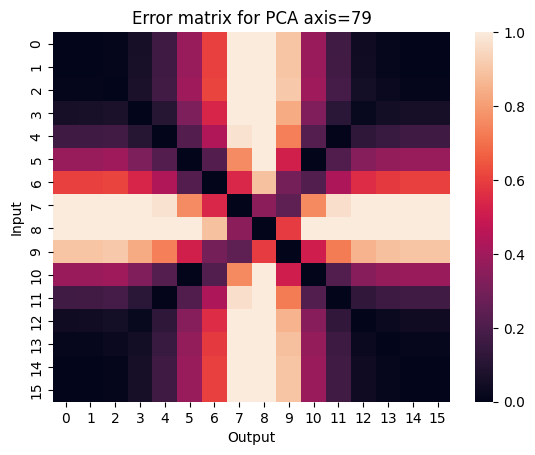

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


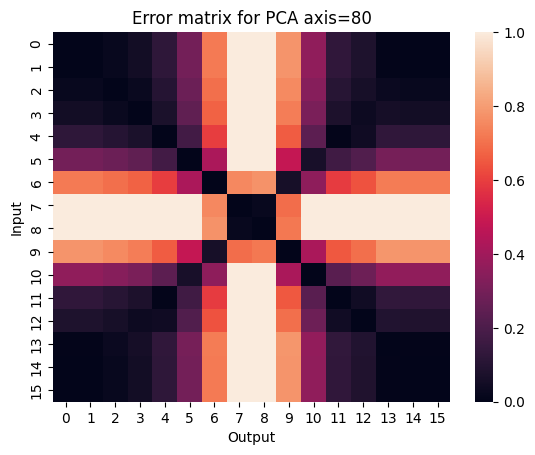

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


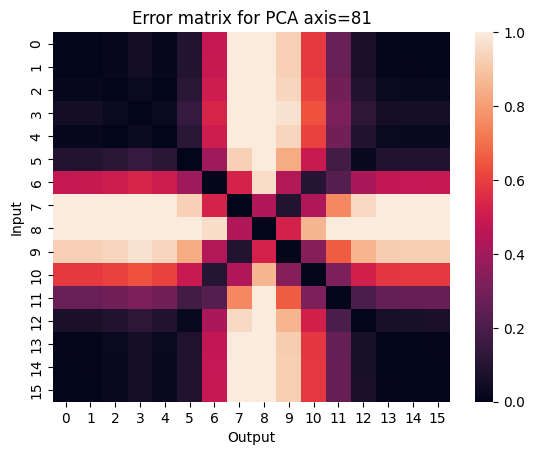

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


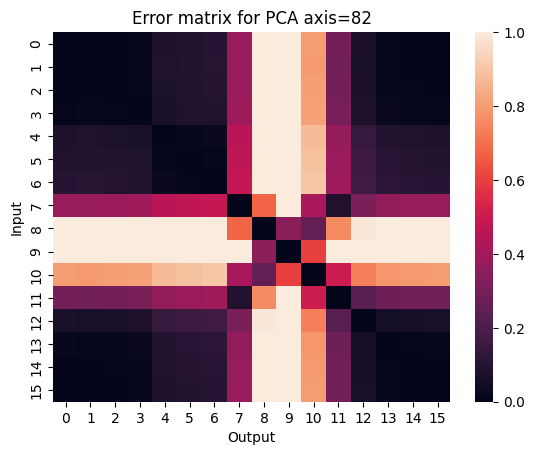

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


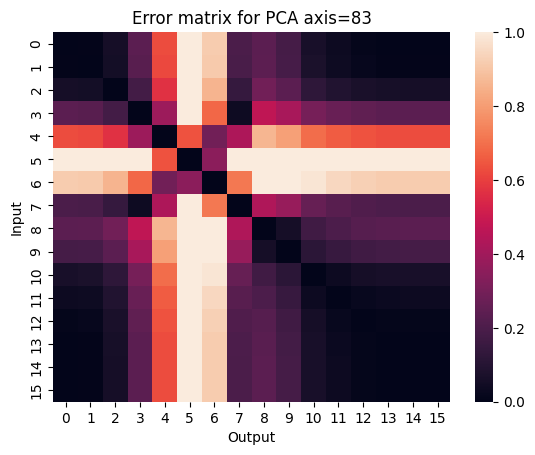

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


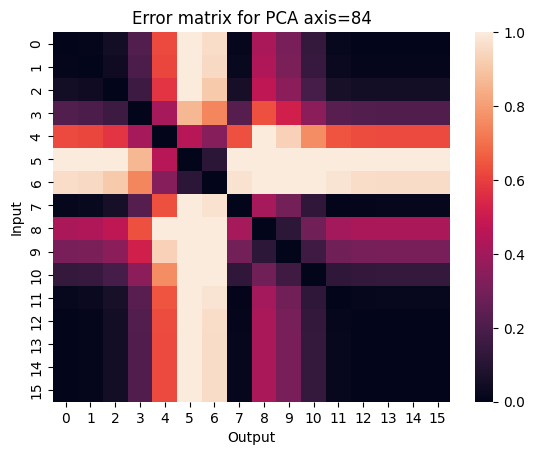

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


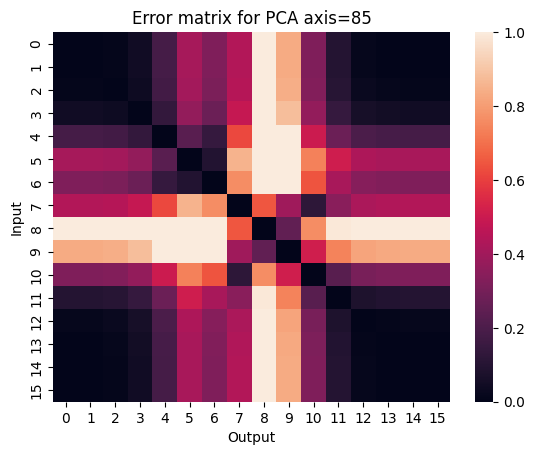

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


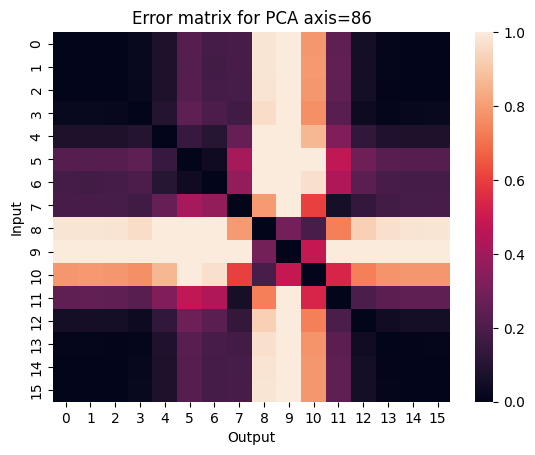

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


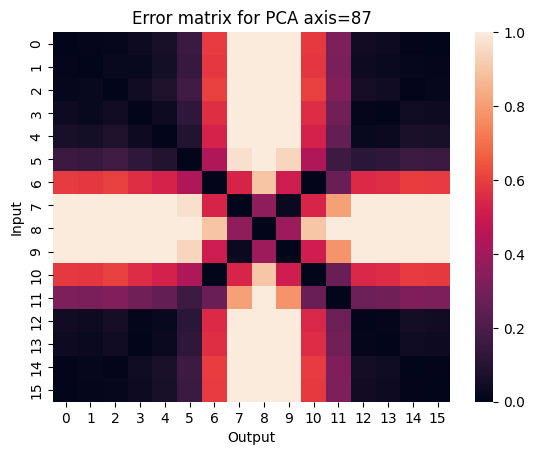

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


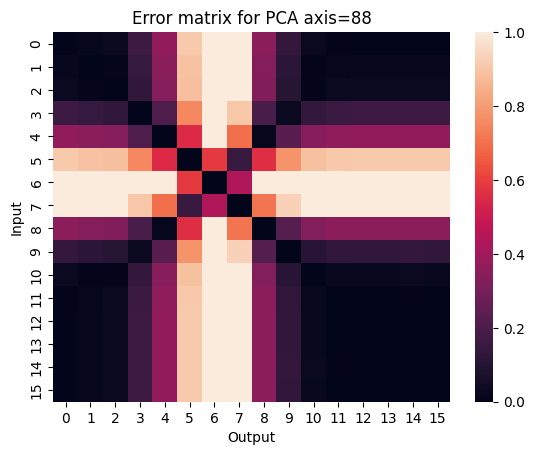

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


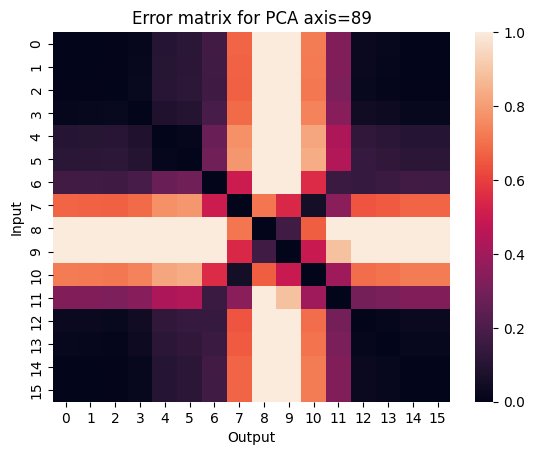

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


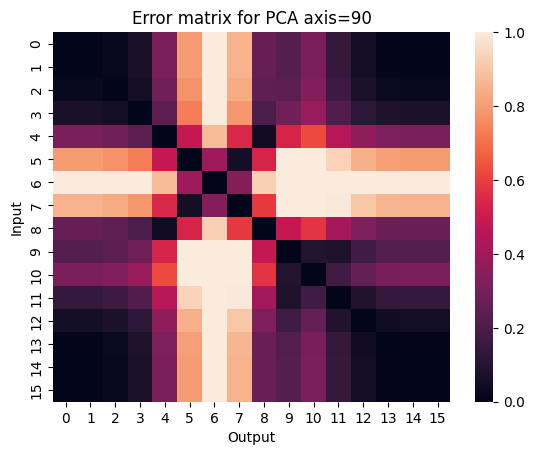

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


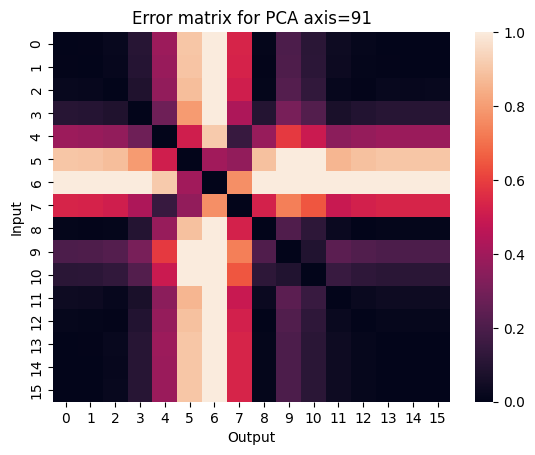

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


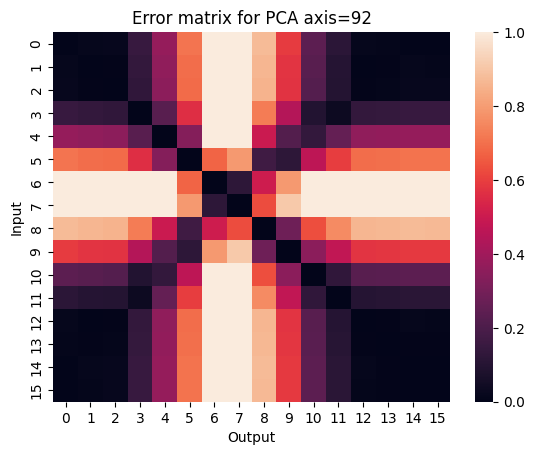

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


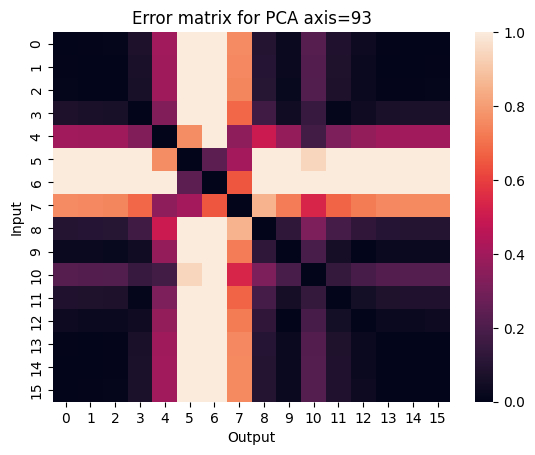

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


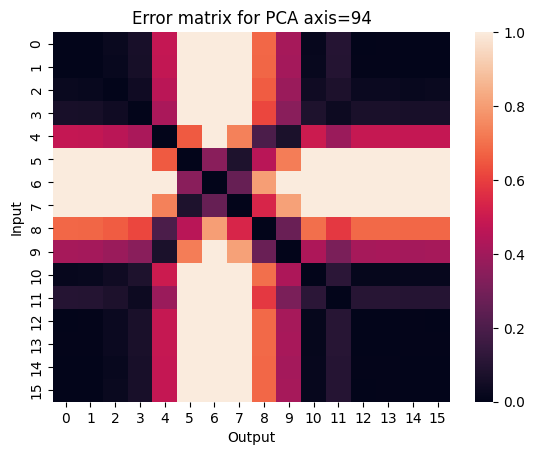

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


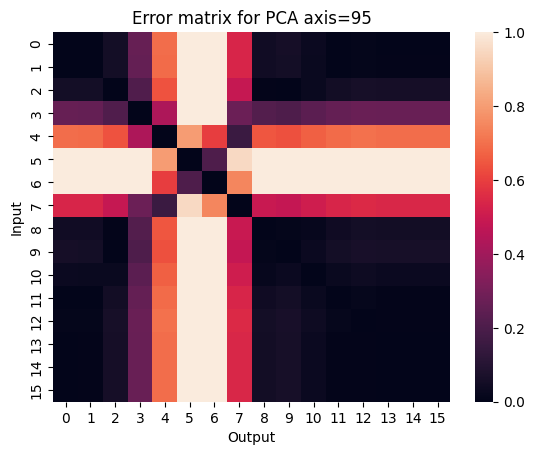

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


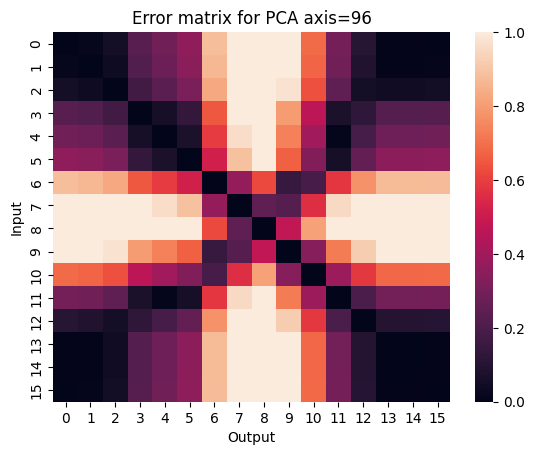

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


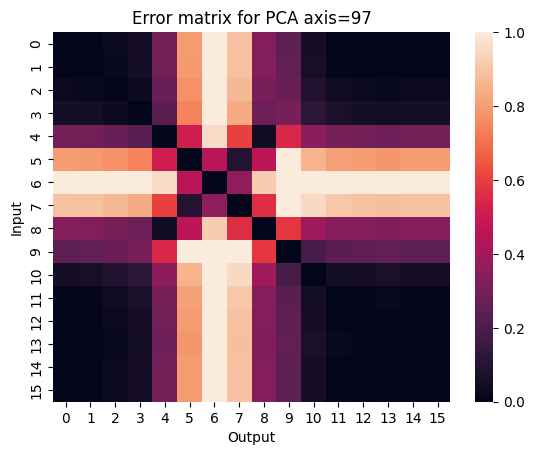

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


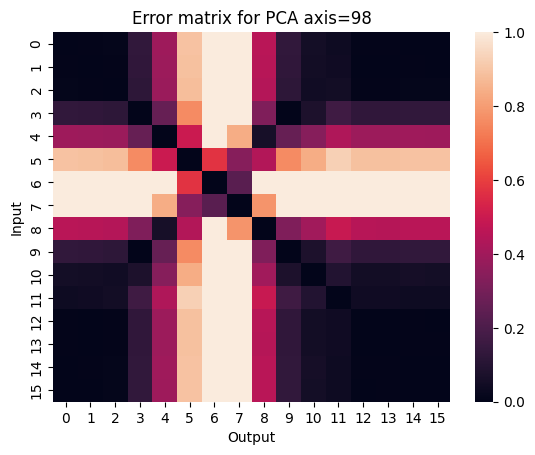

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


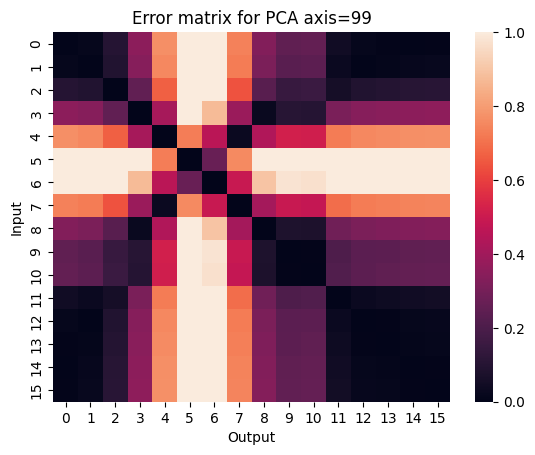

(182339,) (182339, 40)
Positive  87913
Negative  94426
positive_coefficient  1


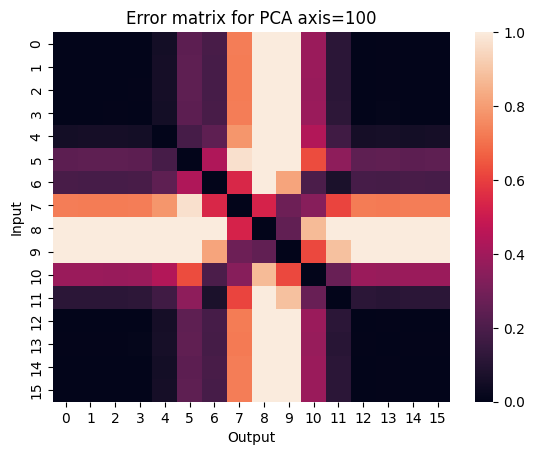

In [9]:
optimal_rr_mechanism_list = []
repetitive_optimizer_list = []
discrete_levels = np.arange(NUM_DISCRETE_VALUES)

for axis__ in range(100):
    error_matrix = cal_error_matrix(transpose_transform_x_train[axis__], y_train, ATTRIBUTE_NUM, discrete_levels)
    sns.heatmap(error_matrix)
    plt.title(f'Error matrix for PCA axis={axis__+1}')
    plt.ylabel('Input')
    plt.xlabel('Output')
    plt.show()  
    # Initialize optimize RR
    # optimal_rr_mechanism = Optimized_Randomized_Response(prior_dist = histogram_list[axis__], STATE_COUNT = NUM_DISCRETE_VALUES, INPUT_ALPHABET = discrete_levels, normalized_objective_err_matrix = error_matrix, 
    #              TOLERANCE_MARGIN = 0.01, APPROXIMATION = "LINEAR", solver = SOLVER, is_kl_div = False, ALPHA=0.01)
    # repetitive_optimizer = Repetitive_optimizer(prior_dist=histogram_list[axis__], normalized_err_matrix=error_matrix, TOLERANCE_MARGIN = 0.001, APPROXIMATION = "LINEAR", STATE_COUNT = NUM_DISCRETE_VALUES)
    # repetitive_optimizer.get_optimal_mechanism(min_utility_err=MAX_UTILITY_ERR_ALOWED, optimizer=optimal_rr_mechanism.optimizer)

    # optimal_rr_mechanism_list.append(optimal_rr_mechanism)
    # repetitive_optimizer_list.append(repetitive_optimizer)
    
    # Create a heatmap
    



In [10]:
  transform_cond = pca.transform(scaler.transform(np.reshape(cond.cpu().numpy(), (1, -1))))

    perturbed_latent = dp_latent(np.reshape(transform_cond, 512), EPS)

    X_recovered = pca.inverse_transform(np.reshape(perturbed_latent, (1,-1)))
    X_original_unscaled = scaler.inverse_transform(X_recovered)

IndentationError: unexpected indent (3415179930.py, line 3)

## Mutual Information calculation

In [ ]:
output = pair_wise_mutual_info(X_train[:1000,:300], estimator="KSG")

In [ ]:
print(np.shape(output))


In [ ]:
# Create a heatmap
sns.heatmap(output, vmin=0.05, vmax=0.1)

# Adding labels and title, if desired
plt.title('Pair-wise MI in PCA')
plt.xlabel('Axis')
plt.ylabel('Axis')

# Display the heatmap
plt.show()


In [ ]:
output_2 = pair_wise_mutual_info(X_train_ori[:1000,:300], estimator="KSG")

In [ ]:
# Create a heatmap
sns.heatmap(output_2, vmin=0.05, vmax=0.1)

# Adding labels and title, if desired
plt.title('Pair-wise MI (Original axes)')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# Display the heatmap
plt.show()


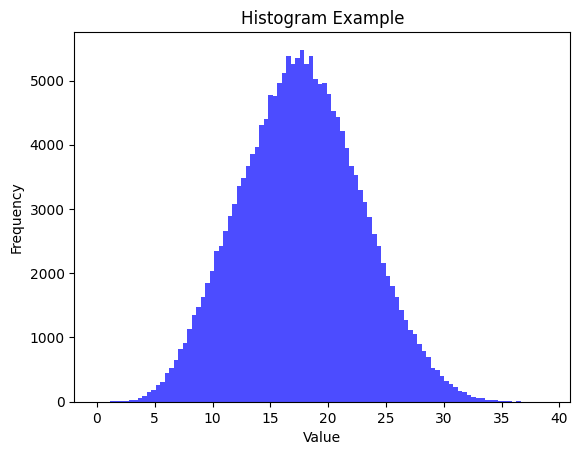

In [ ]:


# Sample data - generating 1000 random numbers from a normal distribution
data = np.random.randn(1000)

# Create histogram
plt.hist(transpose_transform_x_train[2], bins=100, alpha=0.7, color='blue')

# Add titles and labels
plt.title('Histogram Example')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show plot
plt.show()


In [ ]:
plt.scatter(normalized_data[:500], np.transpose(y_train)[36][:500])